## Import Stuff

In [1]:
#Importing stuff
import os
import numpy as np
import matplotlib.pyplot as plt

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

Using TensorFlow backend.


## Data Download and Preporcessing

1. Download and uncompress the raw IMDB data.
2. parse review and label into list with corresponding indices.

In [2]:
# Download and extract the data
!wget  https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
!tar -xzf aclImdb_v1.tar.gz
!rm -r aclImdb_v1.tar.gz

--2020-04-19 13:55:09--  https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
Resolving ai.stanford.edu (ai.stanford.edu)... 171.64.68.10
Connecting to ai.stanford.edu (ai.stanford.edu)|171.64.68.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 84125825 (80M) [application/x-gzip]
Saving to: ‘aclImdb_v1.tar.gz’

aclImdb_v1.tar.gz   100%[===================>]  80.23M  20.0MB/s    in 6.7s    

2020-04-19 13:55:16 (11.9 MB/s) - ‘aclImdb_v1.tar.gz’ saved [84125825/84125825]



In [0]:
# processing the labels of raw imdb data
imdb_dir = 'aclImdb'
train_dir = os.path.join(imdb_dir, 'train')

labels = []
texts = []
for label_type in ['neg', 'pos']:
    dir_name = os.path.join(train_dir, label_type)
    for fname in os.listdir(dir_name):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname))
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)

##### tokenizing the text of raw input data

In [4]:
maxlen = 100                        # max lenght of document  = 100
training_samples = 8000              # Number of samples/documents = 8000 as asked in assignment
validation_samples = 10000          # Validates on 10,000 samples
max_words = 10000                   # only top 10,000 words to be used based on magnitude of count

# Tokenizing
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

# Creating index values for the words
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

# Padding the sequences which fall short of lenght of words 100
data = pad_sequences(sequences, maxlen=maxlen)

# Converting label list into np array
labels = np.asarray(labels)
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

Found 88582 unique tokens.
Shape of data tensor: (25000, 100)
Shape of label tensor: (25000,)


### Data Split
Split the data into a training set and a validation set.
Shuffle the data before split.

In [0]:
# Random Shuffling
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

# Train and validation split
x_train = data[:training_samples]
y_train = labels[:training_samples]
x_val = data[training_samples: training_samples + validation_samples]
y_val = labels[training_samples: training_samples + validation_samples]

## EMBEDDINGS

### Download and unzip glove word embedding

In [6]:
!wget https://github.com/allenai/spv2/raw/master/model/glove.6B.100d.txt.gz 
!gzip -d glove.6B.100d.txt.gz

--2020-04-19 13:55:42--  https://github.com/allenai/spv2/raw/master/model/glove.6B.100d.txt.gz
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://media.githubusercontent.com/media/allenai/spv2/master/model/glove.6B.100d.txt.gz [following]
--2020-04-19 13:55:43--  https://media.githubusercontent.com/media/allenai/spv2/master/model/glove.6B.100d.txt.gz
Resolving media.githubusercontent.com (media.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to media.githubusercontent.com (media.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 134409071 (128M) [application/octet-stream]
Saving to: ‘glove.6B.100d.txt.gz’

glove.6B.100d.txt.g 100%[===================>] 128.18M   100MB/s    in 1.3s    

2020-04-19 13:55:51 (100 MB/s) - ‘glove.6B.100d.txt.gz’ saved [1344

In [7]:
# Parsing the GloVe word-embeddings file
glove_dir = ''
embeddings_index = {}
f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


### Embedding matrix
shape:  (max_words, embedding_dim)


In [0]:
# GloVe word_embeddings matrix
embedding_dim = 100
embedding_matrix = np.zeros((max_words, embedding_dim))

for word, i in word_index.items():
    if i < max_words:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

In [9]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense
from keras.callbacks import ModelCheckpoint

# Defining simple model
model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
flatten_1 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                320032    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________


In [0]:
# loading GLOVE EMBEDDINGS As weights in layer0// trainable==False
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

In [11]:
# training and evaluation
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])

checkpoint = ModelCheckpoint('pre_trained_glove_model.h5', monitor='val_acc', verbose=1, save_best_only=True, mode='max')

history = model.fit(x_train, y_train,
                    epochs=40,
                    batch_size=32,
                    validation_data=(x_val, y_val),
                    callbacks=[checkpoint])


Train on 8000 samples, validate on 10000 samples
Epoch 1/40
8000/8000 [==============================] - 3s 399us/step - loss: 0.6973 - acc: 0.6051 - val_loss: 0.6264 - val_acc: 0.6546

Epoch 00001: val_acc improved from -inf to 0.65460, saving model to pre_trained_glove_model.h5
Epoch 2/40
8000/8000 [==============================] - 2s 191us/step - loss: 0.5561 - acc: 0.7170 - val_loss: 0.6187 - val_acc: 0.6716

Epoch 00002: val_acc improved from 0.65460 to 0.67160, saving model to pre_trained_glove_model.h5
Epoch 3/40
8000/8000 [==============================] - 2s 195us/step - loss: 0.4749 - acc: 0.7732 - val_loss: 0.5718 - val_acc: 0.7033

Epoch 00003: val_acc improved from 0.67160 to 0.70330, saving model to pre_trained_glove_model.h5
Epoch 4/40
8000/8000 [==============================] - 2s 193us/step - loss: 0.4074 - acc: 0.8159 - val_loss: 0.6029 - val_acc: 0.6977

Epoch 00004: val_acc did not improve from 0.70330
Epoch 5/40
8000/8000 [==============================] - 2s 194

In [12]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [13]:
!cp pre_trained_glove_model.h5 '/content/drive/My Drive/EVA2019/Phase2/Session1 Neural Word Embeddings/'

cp: cannot create regular file '/content/drive/My Drive/EVA2019/Phase2/Session1 Neural Word Embeddings/': No such file or directory


## Results

In [0]:
##### plotting the results
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

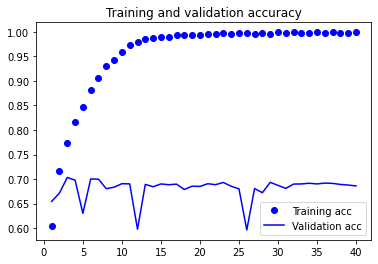

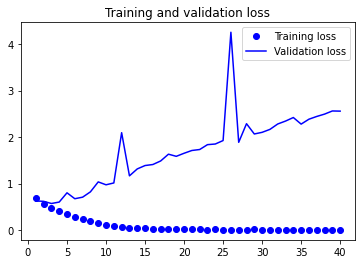

In [15]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

## Testing the model performance

In [0]:
# Test Data
test_dir = os.path.join(imdb_dir, 'test')
labels = []
texts = []
for label_type in ['neg', 'pos']:
    dir_name = os.path.join(test_dir, label_type)
    for fname in sorted(os.listdir(dir_name)):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname), encoding="utf-8")
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)

sequences = tokenizer.texts_to_sequences(texts)
x_test = pad_sequences(sequences, maxlen=maxlen)
y_test = np.asarray(labels)


In [18]:
model.load_weights('pre_trained_glove_model.h5')
model.evaluate(x_test, y_test)

25000/25000 [==============================] - 2s 61us/step


[0.5692998806667328, 0.7042400240898132]